In [13]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import transforms
from torchinfo import summary
import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [14]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cpu device


In [15]:
# get data
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [16]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [17]:
# depending on the paper, the image size is 224 * 224
IMG_SIZE = 224

trans = transforms.Compose([
        transforms.Resize([IMG_SIZE, IMG_SIZE]),
        transforms.ToTensor()
])

print("transforms without normalization: ", trans)

transforms without normalization:  Compose(
    Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [18]:
# Original = 4096
BATCH_SIZE = 32 # limitation from GPU

train_data, test_data, class_names = data_setup.create_dataloaders(
        train_dir = train_dir,
        test_dir = test_dir,
        transform = trans,
        batch_size = BATCH_SIZE
)

train_data, test_data, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fa568082ca0>,
 ['pizza', 'steak', 'sushi'])

Text(0.5, 1.0, 'sushi')

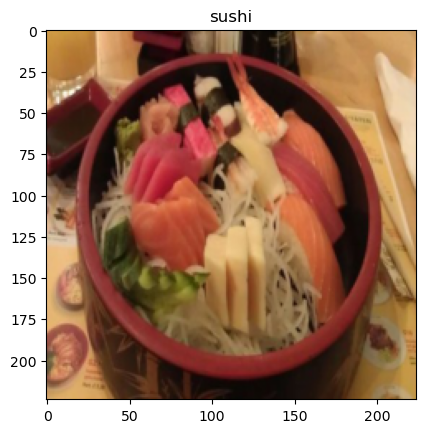

In [19]:
# Visualization
images, labels = next(iter(train_data))
img, label = images[0], labels[0]

plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])

In [20]:
images.shape

torch.Size([32, 3, 224, 224])

## Calculate patch embedding input and output shapes

In [21]:
height = 224
width = 224
color_channels = 3
patch_size = 16

patches_num = (height * width) // (patch_size ** 2)
print(f"Total number of patches {patches_num}\nEach Patch's Size: {patch_size} with resolution "
      f"{patch_size ** 2}\nOriginal Image Height: {height} Width: {width} Channels: {color_channels}")

Total number of patches 196
Each Patch's Size: 16 with resolution 256
Original Image Height: 224 Width: 224 Channels: 3


In [22]:
embedding_layer_in_shape = (height, width, color_channels)
embedding_layer_out_shape = (patches_num, patch_size **2 * color_channels)

print(f"Input Shape: {embedding_layer_in_shape}\nOutput Shape: {embedding_layer_out_shape}")

Input Shape: (224, 224, 3)
Output Shape: (196, 768)


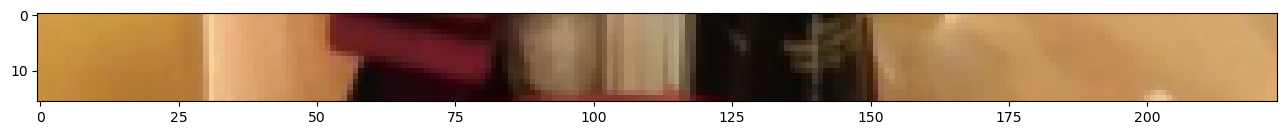

In [23]:
img_permuted = img.permute(1, 2, 0)

plt.figure(figsize = (patch_size, patch_size))
plt.imshow(img_permuted[:patch_size, :, :])
plt.show()

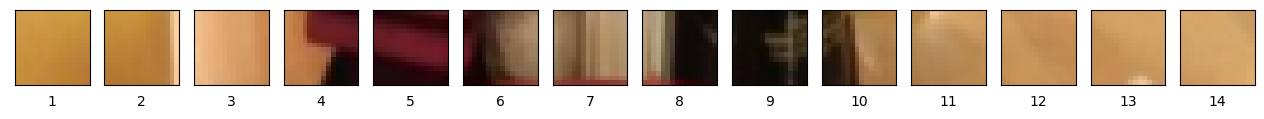

In [24]:
fig, axs = plt.subplots(
    1, height // patch_size,
    figsize = (patch_size, patch_size),
    sharex = True,
    sharey = True)

for i, patch in enumerate(range(0, height, patch_size)):
    axs[i].imshow(img_permuted[:patch_size, patch : patch + patch_size, :])
    axs[i].set_xlabel(i + 1)
    # hide the tick marks on the x-axis and y-axis
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.show()

In [25]:
# show the entire patched image
fig, axs = plt.subplots(
        nrows = height // patch_size,
        ncols = height // patch_size,
        figsize = (patches_num, patches_num),
        sharex = True,
        sharey = True
)

for i, patch_h in enumerate(range(0, height, patch_size)):
    for j, patch_w in enumerate(range(0, width, patch_size)):
        axs[i, j].imshow(img_permuted[patch_h:patch_size + patch_h, patch_w:patch_w + patch_size,
                         :])
        axs[i, j].set_ylabel(i + 1,
                             rotation = "horizontal",
                             horizontalalignment = "right",
                             verticalalignment = "center"
                             )
        axs[i, j].set_xlabel(j + 1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle("Patched Image")
plt.show()

In [26]:
# patch and flatten by Conv2D()
conv2d_layer = nn.Conv2d(3, 768, patch_size, patch_size, 0)
print(conv2d_layer)
# pass a single iamge through it
image_out_of_conv = conv2d_layer(img.unsqueeze(0))
print(image_out_of_conv.shape)

shape = image_out_of_conv.shape
print("batch size =", shape[0])
print("embedding dim =", shape[1])
print("feature map height =", shape[2])
print("feature map width =", shape[3])

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
torch.Size([1, 768, 14, 14])
batch size = 1
embedding dim = 768
feature map height = 14
feature map width = 14


Randomly picked 5 indices are [188, 247, 257, 539, 589]
5 Random Feature Map: 


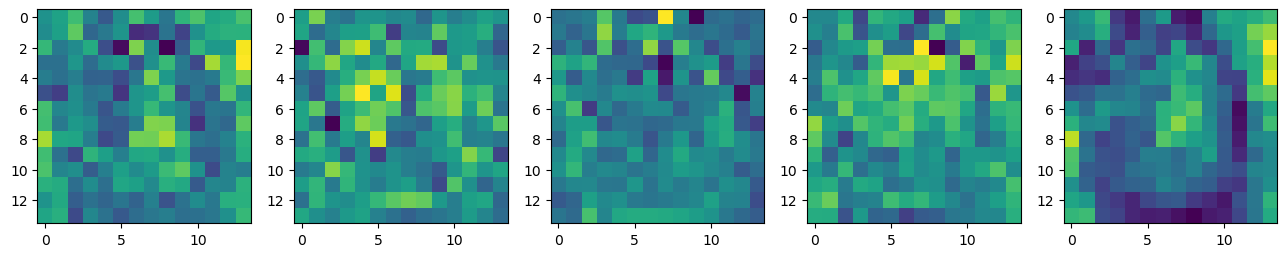

In [27]:
# randomly pick out 5 feature maps
import random

rand_idx = random.sample(range(0, 768), k = 5)
print(f"Randomly picked 5 indices are {rand_idx}")

# visualization
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (16, 16))

for i, idx in enumerate(rand_idx):
    img_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(img_feature_map.squeeze().detach().numpy())

print("5 Random Feature Map: ")
plt.show()

In [28]:
# then flatten the spatial dimensions of the feature map
# only flatten:
# 1. the feature map height (dim = 2)
# 2. the feature map width (dim = 3)
flatten = nn.Flatten(start_dim = 2, end_dim = 3)
image_out_of_flatten = flatten(image_out_of_conv)
print(f"Flattend Image:", image_out_of_flatten.shape)

Flattend Image: torch.Size([1, 768, 196])


In [29]:
# However, we need N * (P ^ 2 * C), which is (196, 768)
image_out_of_flatten = image_out_of_flatten.permute(0, 2, 1)
print(f"Rectified Flattened Shape: {image_out_of_flatten.shape}")

Rectified Flattened Shape: torch.Size([1, 196, 768])


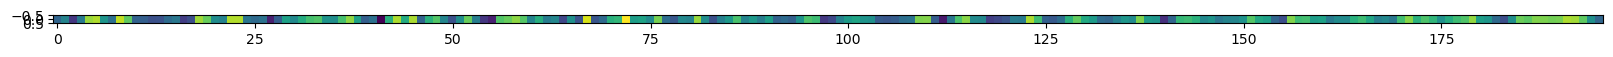

In [30]:
# Visualize a single flattened feature map
single_sample = image_out_of_flatten[:, :, 0]

plt.figure(figsize = (20, 20))
plt.imshow(single_sample.detach().numpy())
plt.show()

In [31]:
# 1. Create a class so that it can be used as a PyTorch layer
class PatchEmbedding(nn.Module):

    #
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768):
        super().__init__()

        # image to patches
        self.patch = nn.Conv2d(in_channels = in_channels,
                               out_channels = embedding_dim,
                               kernel_size = patch_size,
                               stride = patch_size,
                               padding = 0)

        # flatten each patches
        self.flatten = nn.Flatten(start_dim = 2,
                                  end_dim = 3)

    def forward(self, x):
        assert x.shape[-1] % patch_size == 0, f"Input image size: {x.shape[-1]}\n must be " \
                                              f"divisible by patch size {patch_size}."

        x = self.patch(x)
        x = self.flatten(x)

        return x.permute(0, 2, 1) # make sure [batch_size, N, P^2 * C (D)]


In [32]:
# verification on one image
set_seeds()
patchify = PatchEmbedding(in_channels = 3, patch_size = 16, embedding_dim = 768)

# pass a single image
print(f'Input image shape: {img.shape}')
processed_image = patchify(img.unsqueeze(0))
print(f'Output image shape: {processed_image.shape}')

Input image shape: torch.Size([3, 224, 224])
Output image shape: torch.Size([1, 196, 768])


In [33]:
summary(PatchEmbedding(),
        input_size = (1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 10,
        row_settings = ["var_names"])

Layer (type (var_name))                  Input Shape Output Shape Param #    Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224] [1, 196, 768] --         True
├─Conv2d (patch)                         [1, 3, 224, 224] [1, 768, 14, 14] 590,592    True
├─Flatten (flatten)                      [1, 768, 14, 14] [1, 768, 196] --         --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [34]:
batch_size = processed_image.shape[0]
embedding_dimension = processed_image.shape[-1]

# [batch_size, token_num, embedding_dim]
class_tocken = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), requires_grad = True)

processed_image_with_class_embedding = torch.cat((class_tocken, processed_image), dim = 1)

print(f"Sequence of patch embeddings with single class token prepended shape: "
      f"{processed_image_with_class_embedding.shape}")


Sequence of patch embeddings with single class token prepended shape: torch.Size([1, 197, 768])


In [35]:
# N = HW/P^2, D = P^2 * C
position_embedding = nn.Parameter(torch.randn(1, patches_num + 1, embedding_dimension),
                                  requires_grad = True)

print(f"Position embedding size; {position_embedding.shape}")

patch_and_position_embedding = processed_image_with_class_embedding + position_embedding
print(f"Class token prepended patch embedding + position_embedding -> shape: "
      f"{patch_and_position_embedding.shape}")

Position embedding size; torch.Size([1, 197, 768])
Class token prepended patch embedding + position_embedding -> shape: torch.Size([1, 197, 768])


In [36]:
set_seeds()

# 1. set patch size
patch_size = 16

# 2. get the image dimensions
print(f"Image dim: {img.shape}")
height, width = img.shape[1], img.shape[2]

# 3. get image tensor and add batch_size dim
x = img.unsqueeze(0)
print(f'Input image with batch dimension shape: {x.shape}')

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3, patch_size = patch_size, embedding_dim =
768)

# 5. Pass image to the layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), requires_grad = True)
print(f"Class token dimension: {class_token.shape}")

# 7. Concatenate class token to patch embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim = 1)
print(f"Patch embedding with class token shape: {patch_embedding_with_class_token.shape}")


# 8. Create position embedding
patches_num = (height * width) // (patch_size ** 2)
position_embedding = nn.Parameter(torch.randn(batch_size, patches_num + 1, embedding_dimension),
                                  requires_grad = True)

# 9. Add position embedding with class token to patch embedding
final_image = patch_embedding_with_class_token + position_embedding
print(f"patch embedding with class token + position embedding -> shape: {final_image.shape}")



Image dim: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token dimension: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
patch embedding with class token + position embedding -> shape: torch.Size([1, 197, 768])


In [37]:
# MSA
# torch.nn.MultiheadAttention()
# embed_dim = The hidden size D
# num_heads = how many attention heads to use
# dropout = 0; According to appendix B.1, dropout isn't used after the qkv-projections
# batch_first = True; Does our batch dimension come first?

class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim : int = 768,
                 num_heads: int = 12,
                 attention_dropout: float = 0
                 ):
        super().__init__()

        # create the layer norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        self.multihead_attention = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                         num_heads = num_heads,
                                                         dropout = attention_dropout,
                                                         batch_first = True
                                                         )
    def forward(self, x):
        x = self.layer_norm(x)
        attention_output, _ = self.multihead_attention(query = x,
                                                       key = x,
                                                       value = x,
                                                       need_weights = False # do we need the
                                                       # weights or just the layer output?
                                                       )
        return attention_output

In [38]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim = 768, num_heads = 12)

output = multihead_self_attention_block(patch_and_position_embedding)
print(f'Input shape: {patch_and_position_embedding.shape}')
print(f'Output shape: {output.shape}')

Input shape: torch.Size([1, 197, 768])
Output shape: torch.Size([1, 197, 768])


In [39]:
# MLP
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dimension: int = 768,
                 mlp_size: int = 3072, # from Table 1
                 dropout: float = 0.1 # from Table 3
                 ):
        super().__init__()
        self.norm_layer = nn.LayerNorm(normalized_shape = embedding_dimension)
        self.mlp = nn.Sequential(
                nn.Linear(embedding_dimension, mlp_size),
                nn.GELU(),
                nn.Dropout(p = dropout),
                nn.Linear(mlp_size, embedding_dimension),
                nn.Dropout(p = dropout)
        )

    def forward(self, x):
        x = self.norm_layer(x)
        x = self.mlp(x)

        return x


In [40]:
mlp_block = MLPBlock(embedding_dimension = 768, mlp_size = 3072, dropout = 0.1)
print(f"Input Shape: {output.shape}")
output = mlp_block(output) # from the MSA block without residual
print(f"Output Shape: {output.shape}")

Input Shape: torch.Size([1, 197, 768])
Output Shape: torch.Size([1, 197, 768])


In [41]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dimension: int = 768,
                 num_heads: int = 12,
                 mlp_size: int = 3072,
                 mlp_dropout: float = 0.1,
                 attention_dropout: float = 0.
                 ):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim = embedding_dimension,
                                                     num_heads = num_heads, attention_dropout = attention_dropout)
        self.mlp_block = MLPBlock(embedding_dimension = embedding_dimension,
                                  mlp_size = mlp_size,
                                  dropout = mlp_dropout,
                                  )

    def forward(self, x):
        # two residual connection
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [42]:
vit_encoder_block = TransformerEncoderBlock()
summary(
        model = vit_encoder_block,
        input_size = (1, 197, 768),
        col_width = 15,
        col_names = ["input_size",
                    "output_size",
                    "num_params",
                     "trainable"]
)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Trainable
TransformerEncoderBlock                  [1, 197, 768]   [1, 197, 768]   --              True
├─MultiheadSelfAttentionBlock: 1-1       [1, 197, 768]   [1, 197, 768]   --              True
│    └─LayerNorm: 2-1                    [1, 197, 768]   [1, 197, 768]   1,536           True
│    └─MultiheadAttention: 2-2           --              [1, 197, 768]   2,362,368       True
├─MLPBlock: 1-2                          [1, 197, 768]   [1, 197, 768]   --              True
│    └─LayerNorm: 2-3                    [1, 197, 768]   [1, 197, 768]   1,536           True
│    └─Sequential: 2-4                   [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─Linear: 3-1                  [1, 197, 768]   [1, 197, 3072]  2,362,368       True
│    │    └─GELU: 3-2                    [1, 197, 3072]  [1, 197, 3072]  --              --
│    │    └─Dropout: 3-3                 [1, 197, 3072]  

In [43]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

summary(torch_transformer_encoder_layer)

Layer (type:depth-idx)                             Param #
TransformerEncoderLayer                            --
├─MultiheadAttention: 1-1                          1,771,776
│    └─NonDynamicallyQuantizableLinear: 2-1        590,592
├─Linear: 1-2                                      2,362,368
├─Dropout: 1-3                                     --
├─Linear: 1-4                                      2,360,064
├─LayerNorm: 1-5                                   1,536
├─LayerNorm: 1-6                                   1,536
├─Dropout: 1-7                                     --
├─Dropout: 1-8                                     --
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0

In [44]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock
              (
                  embedding_dimension = embedding_dim, num_heads = num_heads,
                  mlp_size = mlp_size,
                  mlp_dropout = mlp_dropout
                  ) for _ in range(num_transformer_layers)]
            )

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x


In [46]:
import engine

vit = ViT()
optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr = 3e-3,
                             betas = (0.9, 0.999),
                             weight_decay = 0.3
                             )

loss = torch.nn.CrossEntropyLoss()
set_seeds()

result = engine.train(vit, train_data, test_data, optimizer, loss, epochs = 10, device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.3586 | train_acc: 0.3008 | test_loss: 3.3096 | test_acc: 0.2604


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5b8e34dc0>
Traceback (most recent call last):
  File "/Users/lipeiran/opt/anaconda3/envs/DeepLearning/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/Users/lipeiran/opt/anaconda3/envs/DeepLearning/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1474, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/lipeiran/opt/anaconda3/envs/DeepLearning/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/lipeiran/opt/anaconda3/envs/DeepLearning/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/lipeiran/opt/anaconda3/envs/DeepLearning/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/Users/lipeiran/opt/anacon

KeyboardInterrupt: 

In [ ]:
# get a pretrained ViT model

import torch, torchvision
print(torch.__version__)
print(torchvision.__version__)

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # default means best available
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

# 2. Freeze the backbone
for para in pretrained_vit.parameters():
    para.requires_grad = False

# 3. Change the top head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features = 768, out_features = len(class_names)).to(device)
pretrained_vit

In [ ]:
# Print a summary using torchinfo
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"]
)

In [ ]:
# 1. download data
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

train_dir = image_path / "train"
test_dir = image_path / "test"

# 2. Prepare dataloader
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = pretrained_vit_transforms,
    batch_size = 32
    )  # Could increase if we had more samples, SEE: https://arxiv.org/abs/2205.01580

# 3. ready to train
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

# 4. plot the loss curves
# Or we can use tensorboard
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

# 5. Save model and deploy model
from going_modular.going_modular import utils
utils.save_model(model = pretrained_vit, target_dir = "model", model_name = "Pretrained_vit.pth")

# 6. get the size of our model
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)

print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")